In [1]:
import json
import subprocess
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import env
from utils import KaggleCameraDataset, progress_iter, RNG

%matplotlib inline
%load_ext autoreload
%autoreload 2

## validation set

In [2]:
N_VAL_PER_CLASS = 75
val, no_val = [], []

### get best images from Gleb's val set (quality $\geq$ 95)

In [3]:
with open('../data/glebs_val_stats.json') as f:
    glebs_val_stats = json.load(f)

In [4]:
gv_yes, gv_no = [], []
for i, d in sorted(glebs_val_stats.items()):
    if d['quality'] and d['quality'] >= 95:
        gv_yes.append((d['x_fpath'], d['y']))
    else:
        gv_no.append((d['x_fpath'], d['y'], d['quality'], d['res'], d['res_valid']))
print len(gv_yes), len(gv_no)

325 9


In [5]:
val += gv_yes
no_val += gv_no

[45, 37, 14, 28, 30, 18, 44, 42, 36, 31]

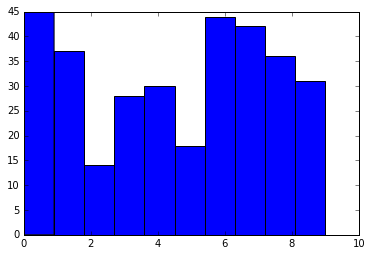

In [6]:
VAL_CLASSES = map(int, plt.hist(zip(*val)[1])[0])
VAL_CLASSES

### get best images from alex firsov val set (quality $\geq$ 95)

In [7]:
with open('../data/alex_firsov_stats.json') as f:
    alex_firsov_stats = json.load(f)

In [8]:
af_yes, af_no = [], []
for i, d in sorted(alex_firsov_stats.items()):
    if d['quality'] and d['quality'] >= 95:
        af_yes.append((d['x_fpath'], d['y'], d['quality'], d['res'], d['res_valid']))
    else:
        af_no.append((d['x_fpath'], d['y'], d['quality'], d['res'], d['res_valid']))
print len(af_yes), len(af_no)

333 11


In [9]:
RNG(seed=1337).shuffle(af_yes)

In [10]:
val += map(lambda (x,y,q,r,rv): (x,y), af_yes[:(N_VAL_PER_CLASS - VAL_CLASSES[2])])
no_val += af_no
no_val += af_yes[(N_VAL_PER_CLASS - VAL_CLASSES[2]):]

[45, 37, 75, 28, 30, 18, 44, 42, 36, 31]

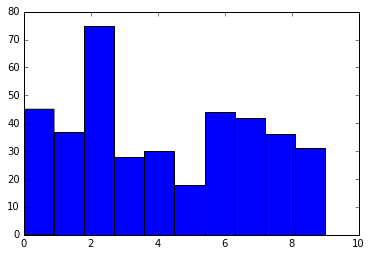

In [11]:
VAL_CLASSES = map(int, plt.hist(zip(*val)[1])[0])
VAL_CLASSES

### fill other classes with $\geq$ 95 from esato

In [12]:
with open('../data/esato_stats.json') as f:
    esato_stats = json.load(f)

In [13]:
es_yes, es_no = [], []
for i, d in sorted(esato_stats.items()):
    if d['x_fpath'].endswith('jpg.1'):
        continue
    if d['quality'] and d['quality'] >= 95:
        es_yes.append((d['x_fpath'], d['y'], d['quality'], d['res'], d['res_valid']))
    else:
        es_no.append((d['x_fpath'], d['y'], d['quality'], d['res'], d['res_valid']))
print len(es_yes), len(es_no)

1063 89


[2, 0, 15, 0, 362, 0, 6, 0, 546, 132]

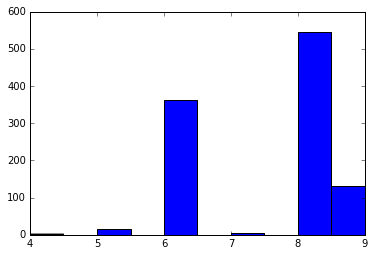

In [14]:
map(int, plt.hist(zip(*es_yes)[1])[0])

#### add all with valid resolution first

[1, 0, 0, 0, 0, 0, 89, 0, 0, 4]

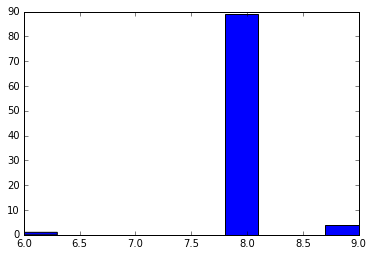

In [15]:
map(int, plt.hist(zip(*filter(lambda (x,y,q,r,rv): rv, es_yes))[1])[0])

In [16]:
es_yes_valid = filter(lambda (x,y,q,r,rv): rv, es_yes)
es_yes_not_valid = filter(lambda (x,y,q,r,rv): not rv, es_yes)

In [ ]:
for x,y,q,r,rv in es_yes_valid:
    VAL_CLASSES = map(int, plt.hist(zip(*val)[1])[0])
    if VAL_CLASSES[y] < N_VAL_PER_CLASS:
        val.append((x, y))
    else:
        no_val.append((x,y,q,r,rv))

[45, 37, 75, 28, 30, 18, 45, 42, 75, 35]

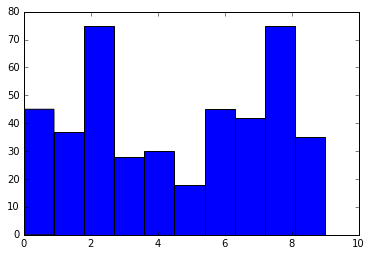

In [18]:
VAL_CLASSES = map(int, plt.hist(zip(*val)[1])[0])
VAL_CLASSES

#### now add with incorrect resolution

In [ ]:
RNG(seed=42).shuffle(es_yes_not_valid)
for x,y,q,r,rv in es_yes_not_valid:
    VAL_CLASSES = np.bincount(zip(*val)[1])
    if VAL_CLASSES[y] < N_VAL_PER_CLASS:
        val.append((x, y))
    else:
        no_val.append((x,y,q,r,rv))

[45, 37, 75, 28, 32, 33, 75, 48, 75, 75]

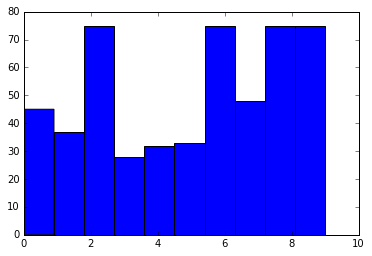

In [22]:
VAL_CLASSES = map(int, plt.hist(zip(*val)[1])[0])
VAL_CLASSES

In [23]:
no_val += es_no

### fill validation set up from original dataset

In [28]:
with open('../data/orig_stats.json') as f:
    train_stats = json.load(f)

In [29]:
RNG(seed=777).shuffle(train_stats)

In [30]:
for x,y,q in train_stats:
    VAL_CLASSES = np.bincount(zip(*val)[1])
    if q >= 95 and VAL_CLASSES[y] < N_VAL_PER_CLASS:
        val.append((x, y))
    else:
        no_val.append((x,y,q,None,True))

[75, 75, 75, 75, 75, 75, 75, 75, 75, 75]

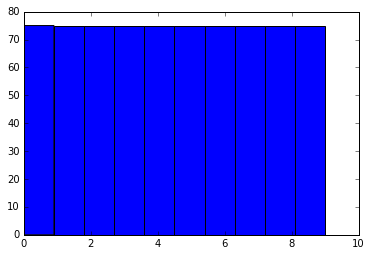

In [31]:
VAL_CLASSES = map(int, plt.hist(zip(*val)[1])[0])
VAL_CLASSES

In [50]:
print len(val), len(no_val)

750 3830


## training set
### load Gleb's train and remove $\lt$ 93

In [62]:
QUALITY_THRESHOLD = 93

In [63]:
with open('../data/glebs_train_stats.json') as f:
    glebs_train_stats = json.load(f)

In [64]:
print len(filter(lambda q: q >= QUALITY_THRESHOLD, [v['quality'] for k, v in glebs_train_stats.items()]))

9229


In [65]:
print len(filter(lambda q: not q or q < QUALITY_THRESHOLD, [v['quality'] for k, v in glebs_train_stats.items()]))

1775


In [66]:
print len(filter(lambda q: not q or q < QUALITY_THRESHOLD, [q for x,y,q in train_stats]))

1


In [326]:
train = []
for x,y,q,r,rv in no_val:
    if q >= QUALITY_THRESHOLD:
        train.append((x,y,q,r,rv))
for i, d in sorted(glebs_train_stats.items()):
    if d['quality'] >= QUALITY_THRESHOLD:
        train.append((d['x_fpath'], d['y'], d['quality'], d['res'], d['res_valid']))

In [327]:
len(train)

13004

[1020, 836, 1182, 955, 1623, 954, 1804, 1352, 2102, 1176]

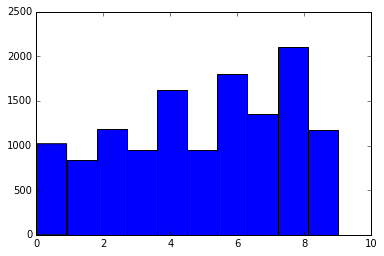

In [328]:
TRAIN_CLASSES = map(int, plt.hist(zip(*train)[1])[0])
TRAIN_CLASSES

In [329]:
M = max(TRAIN_CLASSES)
m = min(TRAIN_CLASSES)
(M - m) / float(M)

0.6022835394862036

### (this also slightly balances train set) remove the most "unlikely resolutions", i.e. with maximal $d(\text{img}, \text{class})=\min_{r \in R_{\text{class}}}\min\{\|r_{\text{img}}-r\|_2, \|r_{\text{img}}-r_{\text{rotated}}\|_2\}$, $r=\begin{pmatrix} h \\ w \end{pmatrix}$

In [330]:
def resolutions(): # with all possible rotations
    return [
        [(1520, 2688), (2688, 1520)],
        [(3024, 4032), (4032, 3024)],
        [(2432, 4320), (4320, 2432)],
        [(1040, 780), (3088, 4130), (4130, 3088), (3120, 4160), (4160, 3120)],
        [(3120, 4160), (4160, 3120)],
        [(4128, 2322)],
        [(4128, 2322)],
        [(6000, 4000)],
        [(3264, 2448)],
        [(3264, 2448)],
    ]

In [331]:
def distance(res, c):
    return min(min([np.sqrt((res[0]-r[0])**2+(res[1]-r[1])**2) for r in resolutions()[c]]),
               min([np.sqrt((res[0]-r[1])**2+(res[1]-r[0])**2) for r in resolutions()[c]]))

In [332]:
len(filter(lambda (x,y,q,r,rv): rv, train)) # with correct resolutions

5060

In [333]:
len(filter(lambda (x,y,q,r,rv): not rv, train))

7944

### e.g., "incorrect iphone4s resolutions"

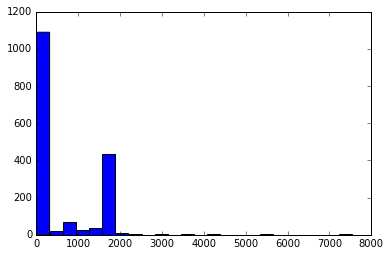

In [334]:
incorrect_iphone4s = filter(lambda (x,y,q,r,rv): not rv and y == 8, train)
dists = map(lambda (x,y,q,r,rv): distance(r, 8), incorrect_iphone4s)
dists.sort()
plt.hist(dists, bins=24);

In [335]:
dists[::-1][40:50]

[1655.9619560847405,
 1631.9571072794774,
 1593.5294161075283,
 1584.788944938726,
 1584.0012626257594,
 1580.0,
 1580.0,
 1580.0,
 1580.0,
 1580.0]

In [336]:
sum(np.asarray(dists) > 1581.)/float(len(dists))

0.026346604215456676

In [337]:
sum(np.asarray(dists) > 1.)/float(len(dists)) # 0 means simply landscape photos

0.38114754098360654

In [338]:
incorrect_iphone4s.sort(key=lambda (x,y,q,r,rv): -distance(r,8))
incorrect_iphone4s[42:50]

[(u'../data/glebs-train/train/iPhone-4s/38290361134_d74e19efa3_o.jpg',
  8,
  96,
  [1698, 1858],
  False),
 (u'../data/esato-com/train/iPhone-4s/201303121858b24wEX.jpg',
  8,
  96,
  [2498, 4848],
  False),
 (u'../data/esato-com/train/iPhone-4s/201212020931H43XZV.jpg',
  8,
  96,
  [2446, 4848],
  False),
 (u'../data/glebs-train/train/iPhone-4s/24694324078_3435e21cd7_o.jpg',
  8,
  99,
  [1500, 2000],
  False),
 (u'../data/glebs-train/train/iPhone-4s/24694337928_76c70409b6_o.jpg',
  8,
  99,
  [1500, 2000],
  False),
 (u'../data/glebs-train/train/iPhone-4s/24694339268_a86b1ce6cd_o.jpg',
  8,
  99,
  [1500, 2000],
  False),
 (u'../data/glebs-train/train/iPhone-4s/24694350208_4cf3f1ea52_o.jpg',
  8,
  99,
  [1500, 2000],
  False),
 (u'../data/glebs-train/train/iPhone-4s/24694359098_9ae4375750_o.jpg',
  8,
  99,
  [1500, 2000],
  False)]

12353


[1020, 836, 1182, 955, 1623, 954, 1804, 1352, 1451, 1176]

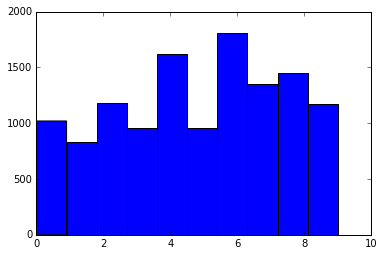

In [339]:
train = filter(lambda (x,y,q,r,rv): y != 8 or (y == 8 and (rv or (not rv and distance(r, 8) < 1.))), train)
print len(train)
TRAIN_CLASSES = map(int, plt.hist(zip(*train)[1])[0])
TRAIN_CLASSES

### incorrect Samsung-Galaxy-S4 resolutions

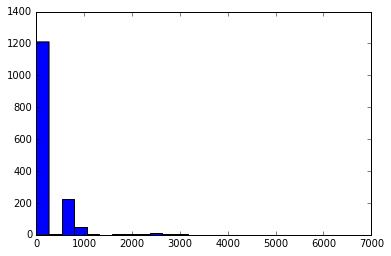

In [340]:
incorrect_S4 = filter(lambda (x,y,q,r,rv): not rv and y == 6, train)
dists = map(lambda (x,y,q,r,rv): distance(r, 6), incorrect_S4)
dists.sort()
plt.hist(dists, bins=24);

12037


[1020, 836, 1182, 955, 1623, 954, 1488, 1352, 1451, 1176]

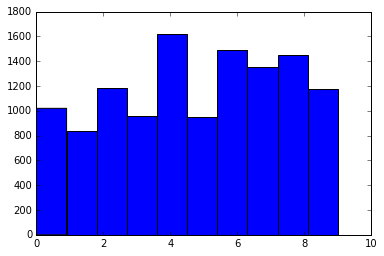

In [341]:
train = filter(lambda (x,y,q,r,rv): y != 6 or (y == 6 and (rv or (not rv and distance(r, 6) < 1.))), train)
print len(train)
TRAIN_CLASSES = map(int, plt.hist(zip(*train)[1])[0])
TRAIN_CLASSES

### incorrect Motorola-X resolutions

1391


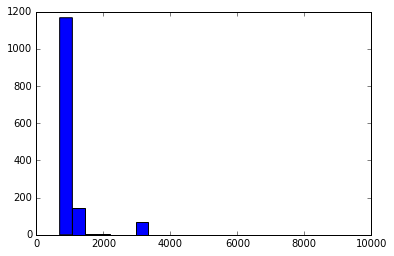

In [342]:
c = 4
incorrect = filter(lambda (x,y,q,r,rv): not rv and y == c, train)
print len(incorrect)
dists = map(lambda (x,y,q,r,rv): distance(r, c), incorrect)
dists.sort()
plt.hist(dists, bins=24);

In [343]:
c = 4
dists = map(lambda (x,y,q,r,rv): distance(r, c), incorrect)
dists.sort()
print dists[1200:1300]

[1160.0, 1160.0, 1160.0, 1160.0, 1160.0, 1160.0, 1160.0, 1160.0, 1160.0, 1160.0, 1160.0, 1160.0, 1160.0, 1160.0, 1160.0, 1160.0, 1160.0, 1160.0, 1160.0, 1160.0, 1160.0, 1160.0, 1160.0, 1160.0, 1160.0, 1160.0, 1160.0, 1160.0, 1160.0, 1160.0, 1160.0, 1160.0, 1160.0, 1160.0, 1160.0, 1160.0, 1160.0, 1160.0, 1160.0, 1160.0, 1160.0, 1160.0, 1160.0, 1160.0, 1160.0, 1160.0, 1160.0, 1160.0, 1160.0, 1160.0, 1160.0, 1160.0, 1160.0, 1160.0, 1160.0, 1160.0, 1160.0, 1160.0, 1160.0, 1160.0, 1160.0, 1160.0, 1160.0, 1160.0, 1160.0, 1160.0, 1160.0, 1160.0, 1160.0, 1160.0, 1160.0, 1160.0, 1160.0, 1160.0, 1160.0, 1160.0, 1160.0, 1160.0, 1160.0, 1160.0, 1160.0, 1160.0, 1160.0, 1160.0, 1160.0, 1160.0, 1160.0, 1160.0, 1160.0, 1160.0, 1160.0, 1160.0, 1160.0, 1160.0, 1160.0, 1160.0, 1160.0, 1160.0, 1160.0, 1160.0]


In [344]:
incorrect.sort(key=lambda (x,y,q,r,rv): -distance(r,4))
incorrect[20:30]

[(u'../data/glebs-train/train/Motorola-X/26444648090_20f9e430f5_o.jpg',
  4,
  95,
  [1920, 1080],
  False),
 (u'../data/glebs-train/train/Motorola-X/26570811436_e45955427c_o.jpg',
  4,
  97,
  [1920, 1080],
  False),
 (u'../data/glebs-train/train/Motorola-X/26676340276_94360de30b_o.jpg',
  4,
  95,
  [1080, 1920],
  False),
 (u'../data/glebs-train/train/Motorola-X/26811730025_6115571fcd_o.jpg',
  4,
  95,
  [1080, 1920],
  False),
 (u'../data/glebs-train/train/Motorola-X/27227817830_f0b2ef4778_o.jpg',
  4,
  97,
  [1920, 1080],
  False),
 (u'../data/glebs-train/train/Motorola-X/27268389961_6b7689717e_o.jpg',
  4,
  95,
  [1080, 1920],
  False),
 (u'../data/glebs-train/train/Motorola-X/27350291351_a0bbbfde52_o.jpg',
  4,
  95,
  [1920, 1080],
  False),
 (u'../data/glebs-train/train/Motorola-X/27387770246_02aef6a5af_o.jpg',
  4,
  95,
  [1920, 1080],
  False),
 (u'../data/glebs-train/train/Motorola-X/27413191824_1e0045f49a_o.jpg',
  4,
  95,
  [1080, 1920],
  False),
 (u'../data/glebs-t

11953


[1020, 836, 1182, 955, 1539, 954, 1488, 1352, 1451, 1176]

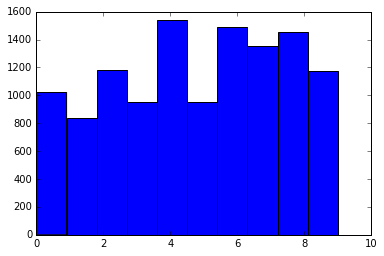

In [345]:
c = 4
train = filter(lambda (x,y,q,r,rv): y != c or (y == c and (rv or (not rv and distance(r, c) < 1161.))), train)
print len(train)
TRAIN_CLASSES = map(int, plt.hist(zip(*train)[1])[0])
TRAIN_CLASSES

### class 2

380


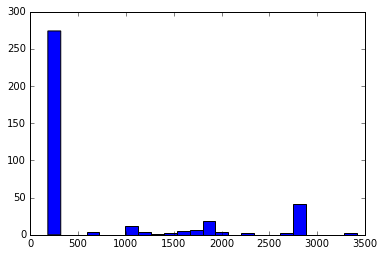

In [346]:
c = 2
incorrect = filter(lambda (x,y,q,r,rv): not rv and y == c, train)
print len(incorrect)
dists = map(lambda (x,y,q,r,rv): distance(r, c), incorrect)
dists.sort()
plt.hist(dists, bins=24);

In [347]:
c = 2
dists = map(lambda (x,y,q,r,rv): distance(r, c), incorrect)
dists.sort()
print dists[:30]

[184.56435192094924, 184.56435192094924, 184.56435192094924, 184.56435192094924, 184.56435192094924, 184.56435192094924, 184.56435192094924, 184.56435192094924, 184.56435192094924, 184.56435192094924, 184.56435192094924, 184.56435192094924, 184.56435192094924, 184.56435192094924, 184.56435192094924, 184.56435192094924, 184.56435192094924, 184.56435192094924, 184.56435192094924, 184.56435192094924, 184.56435192094924, 184.56435192094924, 184.56435192094924, 184.56435192094924, 184.56435192094924, 184.56435192094924, 184.56435192094924, 184.56435192094924, 184.56435192094924, 184.56435192094924]


11847


[1020, 836, 1076, 955, 1539, 954, 1488, 1352, 1451, 1176]

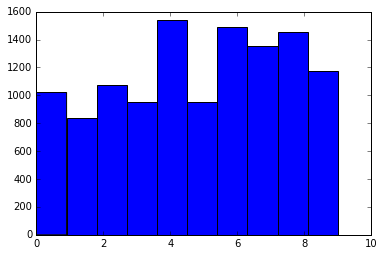

In [348]:
c = 2
train = filter(lambda (x,y,q,r,rv): y != c or (y == c and (rv or (not rv and distance(r, c) < 185.))), train)
print len(train)
TRAIN_CLASSES = map(int, plt.hist(zip(*train)[1])[0])
TRAIN_CLASSES

### class 9

741


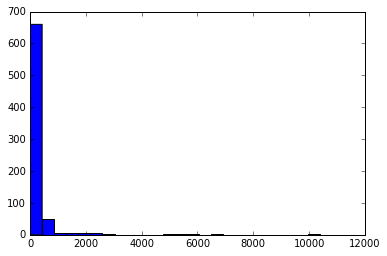

In [349]:
c = 9
incorrect = filter(lambda (x,y,q,r,rv): not rv and y == c, train)
print len(incorrect)
dists = map(lambda (x,y,q,r,rv): distance(r, c), incorrect)
dists.sort()
plt.hist(dists, bins=24);

11743


[1020, 836, 1076, 955, 1539, 954, 1488, 1352, 1451, 1072]

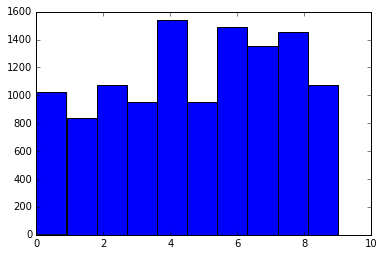

In [350]:
c = 9
train = filter(lambda (x,y,q,r,rv): y != c or (y == c and (rv or (not rv and distance(r, c) < 1.))), train)
print len(train)
TRAIN_CLASSES = map(int, plt.hist(zip(*train)[1])[0])
TRAIN_CLASSES

### class 7

1076


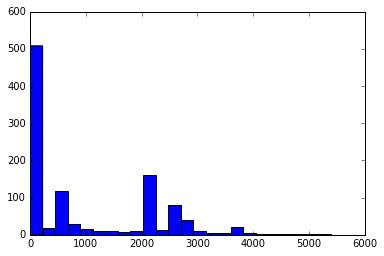

In [351]:
c = 7
incorrect = filter(lambda (x,y,q,r,rv): not rv and y == c, train)
print len(incorrect)
dists = map(lambda (x,y,q,r,rv): distance(r, c), incorrect)
dists.sort()
plt.hist(dists, bins=24);

In [352]:
dists[500:600]
incorrect.sort(key=lambda (x,y,q,r,rv): -distance(r,c))
incorrect[550:600]

[(u'../data/glebs-train/train/Sony-NEX-7/38653248512_b91ed4e845_o.jpg',
  7,
  96,
  [5630, 3753],
  False),
 (u'../data/glebs-train/train/Sony-NEX-7/37967530344_a1f8336856_o.jpg',
  7,
  96,
  [5646, 3764],
  False),
 (u'../data/glebs-train/train/Sony-NEX-7/37112580226_c98fb4c5c2_o.jpg',
  7,
  96,
  [5600, 4000],
  False),
 (u'../data/glebs-train/train/Sony-NEX-7/38110805492_fa9f7b999a_o.jpg',
  7,
  93,
  [3603, 6000],
  False),
 (u'../data/glebs-train/train/Sony-NEX-7/37967044094_7f21ef19e5_o.jpg',
  7,
  96,
  [5697, 3798],
  False),
 (u'../data/glebs-train/train/Sony-NEX-7/26909773289_d85a255141_o.jpg',
  7,
  96,
  [3809, 5714],
  False),
 (u'../data/glebs-train/train/Sony-NEX-7/38653228162_597508f187_o.jpg',
  7,
  96,
  [3813, 5720],
  False),
 (u'../data/glebs-train/train/Sony-NEX-7/37875538205_8d31186cf8_o.jpg',
  7,
  99,
  [5710, 3832],
  False),
 (u'../data/glebs-train/train/Sony-NEX-7/38653315692_653366e3b9_o.jpg',
  7,
  96,
  [3821, 5731],
  False),
 (u'../data/glebs-t

11305


[1020, 836, 1076, 955, 1539, 954, 1488, 914, 1451, 1072]

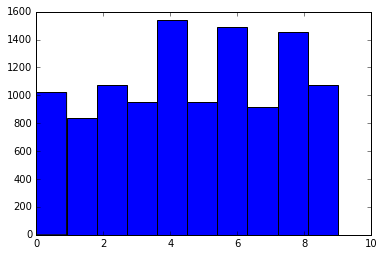

In [353]:
c = 7
train = filter(lambda (x,y,q,r,rv): y != c or (y == c and (rv or (not rv and distance(r, c) < 625.))), train)
print len(train)
TRAIN_CLASSES = map(int, plt.hist(zip(*train)[1])[0])
TRAIN_CLASSES

### class 5

711


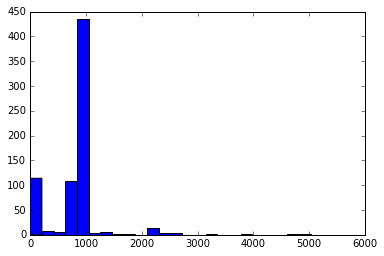

In [354]:
c = 5
incorrect = filter(lambda (x,y,q,r,rv): not rv and y == c, train)
print len(incorrect)
dists = map(lambda (x,y,q,r,rv): distance(r, c), incorrect)
dists.sort()
plt.hist(dists, bins=24);

In [355]:
dists

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 27.784887978899608,
 51.97114584074513,
 66.483080554378645,
 112.37882362794157,
 210.48752932181043,
 211.3575170179665,
 245.93495074917675,
 256.13473017144707,
 300.91194725367751,
 331.0,
 361.81348786356762,
 376.72403692889043,
 477.89538604175704,
 489.00102249381854,
 558.73517877434563,
 569.3856338194704,
 610.0,
 636.0880442

In [356]:
dists[-100:]#, dists[230:260]

[991.30822653703422,
 991.30822653703422,
 991.30822653703422,
 991.30822653703422,
 991.30822653703422,
 991.30822653703422,
 991.30822653703422,
 991.30822653703422,
 991.30822653703422,
 991.30822653703422,
 991.30822653703422,
 991.30822653703422,
 991.30822653703422,
 991.30822653703422,
 991.30822653703422,
 991.30822653703422,
 991.30822653703422,
 991.30822653703422,
 991.30822653703422,
 991.30822653703422,
 991.30822653703422,
 991.30822653703422,
 991.30822653703422,
 991.30822653703422,
 991.30822653703422,
 991.30822653703422,
 991.30822653703422,
 991.30822653703422,
 991.30822653703422,
 991.30822653703422,
 991.30822653703422,
 991.30822653703422,
 991.30822653703422,
 991.30822653703422,
 991.30822653703422,
 991.30822653703422,
 991.30822653703422,
 991.30822653703422,
 991.30822653703422,
 991.30822653703422,
 991.30822653703422,
 991.30822653703422,
 991.30822653703422,
 991.30822653703422,
 991.30822653703422,
 991.30822653703422,
 991.30822653703422,
 991.30822653

In [357]:
incorrect.sort(key=lambda (x,y,q,r,rv): -distance(r,5))
incorrect[130:140]

[(u'../data/glebs-train/train/Samsung-Galaxy-Note3/35117222905_5aa70485e9_o.jpg',
  5,
  96,
  [1836, 3264],
  False),
 (u'../data/glebs-train/train/Samsung-Galaxy-Note3/35231019683_321c9f0a34_o.jpg',
  5,
  93,
  [3264, 1836],
  False),
 (u'../data/glebs-train/train/Samsung-Galaxy-Note3/35569476706_12ecc6623c_o.jpg',
  5,
  96,
  [1836, 3264],
  False),
 (u'../data/glebs-train/train/Samsung-Galaxy-Note3/35754448775_772a29eaca_o.jpg',
  5,
  96,
  [1836, 3264],
  False),
 (u'../data/glebs-train/train/Samsung-Galaxy-Note3/35999662456_1cbe0bb2b5_o.jpg',
  5,
  93,
  [1836, 3264],
  False),
 (u'../data/glebs-train/train/Samsung-Galaxy-Note3/36041325785_0c7c5e0d6b_o.jpg',
  5,
  93,
  [1836, 3264],
  False),
 (u'../data/glebs-train/train/Samsung-Galaxy-Note3/36536643154_869c0d8f86_o.jpg',
  5,
  96,
  [1836, 3264],
  False),
 (u'../data/glebs-train/train/Samsung-Galaxy-Note3/36539428774_6bb1436645_o.jpg',
  5,
  96,
  [3264, 1836],
  False),
 (u'../data/glebs-train/train/Samsung-Galaxy-Not

### same ratio as in training set, keep

11242


[1020, 836, 1076, 955, 1539, 891, 1488, 914, 1451, 1072]

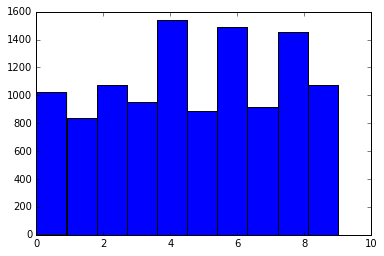

In [358]:
c = 5
train = filter(lambda (x,y,q,r,rv): y != c or (y == c and (rv or (not rv and ((distance(r, c) < 1.) or (773. < distance(r, c) < 992.))))), train)
print len(train)
TRAIN_CLASSES = map(int, plt.hist(zip(*train)[1])[0])
TRAIN_CLASSES

### class 0

33


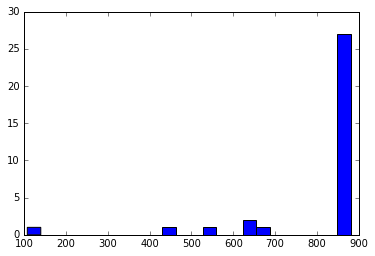

In [359]:
c = 0
incorrect = filter(lambda (x,y,q,r,rv): not rv and y == c, train)
print len(incorrect)
dists = map(lambda (x,y,q,r,rv): distance(r, c), incorrect)
dists.sort()
plt.hist(dists, bins=24);

#### simply remove all incorrect

11209


[987, 836, 1076, 955, 1539, 891, 1488, 914, 1451, 1072]

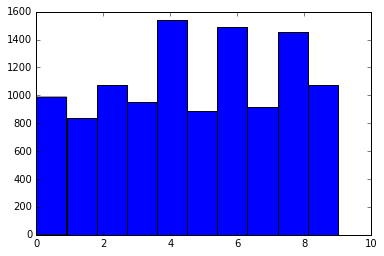

In [360]:
c = 0
train = filter(lambda (x,y,q,r,rv): y != c or (y == c and rv), train)
print len(train)
TRAIN_CLASSES = map(int, plt.hist(zip(*train)[1])[0])
TRAIN_CLASSES

### class 1

206


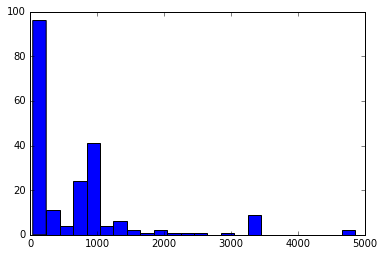

In [361]:
c = 1
incorrect = filter(lambda (x,y,q,r,rv): not rv and y == c, train)
print len(incorrect)
dists = map(lambda (x,y,q,r,rv): distance(r, c), incorrect)
dists.sort()
plt.hist(dists, bins=24);

In [362]:
dists[:200]

[40.0,
 45.254833995939045,
 45.254833995939045,
 45.254833995939045,
 45.254833995939045,
 45.254833995939045,
 45.254833995939045,
 45.254833995939045,
 45.254833995939045,
 45.254833995939045,
 45.254833995939045,
 45.254833995939045,
 45.254833995939045,
 45.254833995939045,
 45.254833995939045,
 45.254833995939045,
 45.254833995939045,
 45.254833995939045,
 45.254833995939045,
 45.254833995939045,
 45.254833995939045,
 45.254833995939045,
 45.254833995939045,
 45.254833995939045,
 45.254833995939045,
 45.254833995939045,
 45.254833995939045,
 45.254833995939045,
 45.254833995939045,
 45.254833995939045,
 45.254833995939045,
 45.254833995939045,
 45.254833995939045,
 45.254833995939045,
 45.254833995939045,
 45.254833995939045,
 45.254833995939045,
 45.254833995939045,
 45.254833995939045,
 45.254833995939045,
 45.254833995939045,
 45.254833995939045,
 45.254833995939045,
 45.254833995939045,
 45.254833995939045,
 45.254833995939045,
 45.254833995939045,
 45.254833995939045,
 45.25

11142


[987, 769, 1076, 955, 1539, 891, 1488, 914, 1451, 1072]

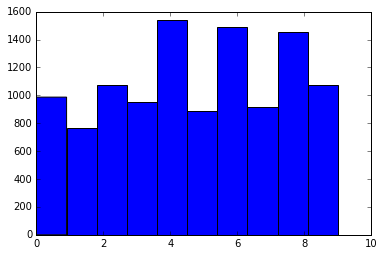

In [363]:
c = 1
train = filter(lambda (x,y,q,r,rv): y != c or (y == c and (rv or (not rv and (distance(r, c) < 885.)))), train)
print len(train)
TRAIN_CLASSES = map(int, plt.hist(zip(*train)[1])[0])
TRAIN_CLASSES

### class 3

175


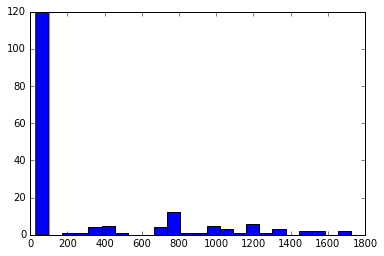

In [364]:
c = 3
incorrect = filter(lambda (x,y,q,r,rv): not rv and y == c, train)
print len(incorrect)
dists = map(lambda (x,y,q,r,rv): distance(r, c), incorrect)
dists.sort()
plt.hist(dists, bins=24);

In [365]:
dists[100:130]

[30.0,
 30.0,
 30.0,
 30.0,
 30.0,
 30.0,
 30.0,
 30.0,
 30.0,
 30.0,
 30.0,
 30.0,
 30.0,
 30.0,
 30.0,
 30.0,
 30.0,
 30.0,
 30.0,
 35.777087639996637,
 185.77674773770801,
 282.85155117128136,
 316.42534664593478,
 329.13371143047624,
 338.00147928670373,
 364.9438312946254,
 403.27162062312294,
 416.20307543313515,
 430.83639586274512,
 449.44410108488466]

11086


[987, 769, 1076, 899, 1539, 891, 1488, 914, 1451, 1072]

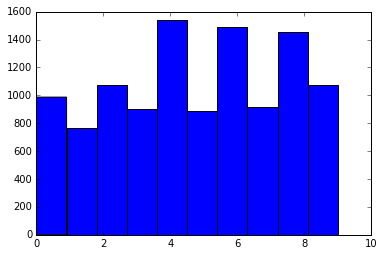

In [366]:
c = 3
train = filter(lambda (x,y,q,r,rv): y != c or (y == c and (rv or (not rv and (distance(r, c) < 31.)))), train)
print len(train)
TRAIN_CLASSES = map(int, plt.hist(zip(*train)[1])[0])
TRAIN_CLASSES

In [367]:
M = max(TRAIN_CLASSES)
m = min(TRAIN_CLASSES)
(M - m) / float(M)

0.5003248862897985

In [368]:
len(train)

11086

## now need to crop and to save images to disk, but now cleverer:
### $\approx$ undersampling, save separate blocks (of $\approx$ same size) for each class

In [402]:
BLOCK_SIZE = 48
N_BLOCKS = [int(np.round(t/float(BLOCK_SIZE))) for t in TRAIN_CLASSES]
N_BLOCKS

[21, 16, 22, 19, 32, 19, 31, 19, 30, 22]

In [ ]:
crop_size = 1024
for c in xrange(10):
    class_train = filter(lambda (x,y,q,r,rv): y == c, train)
    RNG(seed=7331 + c).shuffle(class_train)
    class_blocks = []
    for _ in xrange(N_BLOCKS[c]):
        class_blocks.append([])
    pos = 0
    for x,_,_,_,_ in progress_iter(class_train, True):
        x = Image.open(x)
        w = x.size[0]
        h = x.size[1]
        x = x.crop((w/2-crop_size/2, h/2-crop_size/2,
                    w/2+crop_size/2, h/2+crop_size/2))
        class_blocks[pos % N_BLOCKS[c]].append(np.asarray(x, dtype=np.uint8))
        pos += 1
    for b in xrange(N_BLOCKS[c]):
        np.save('../data/X_{0}_{1}.npy'.format(c, b), np.asarray(class_blocks[b]))

### save validation set

In [369]:
len(val)

750

In [370]:
RNG(seed=9999).shuffle(val)

In [375]:
y_val = np.asarray(zip(*val)[1])
crop_size = c = 1024
X_val = np.zeros((len(y_val), crop_size, crop_size, 3), dtype=np.uint8)
pos = 0
for x, _ in progress_iter(val, True):
    x = Image.open(x)
    w = x.size[0]
    h = x.size[1]
    x = x.crop((w/2-c/2, h/2-c/2,
                w/2+c/2, h/2+c/2))
    X_val[pos] = np.asarray(x, dtype=np.uint8)
    pos += 1
np.save('../data/X_val.npy', X_val)
np.save('../data/y_val.npy', y_val)

A Jupyter Widget